In [31]:
import requests
import os

from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
import faiss
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [10]:
# tweaked from https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel.forward.returns

# below is standard CLIP usage to score text snippets against a photo

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [13]:
def images_to_embeddings(images):
    vinput = processor(images=images, return_tensors="pt")

    voutput = model.vision_model(
        **vinput
    )

    vembeds = voutput[1]

    vembeds = model.visual_projection(vembeds)

    vembeds = vembeds / vembeds.norm(p=2, dim=-1, keepdim=True)
    
    return vembeds

# build amazon dataset

download dataset from https://data.world/promptcloud/amazon-fashion-products-2020/file/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson

In [73]:
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

def download(record):
    try:
        image_url = record["medium"].split("|")[0]
        image_path = os.path.join(self.image_dir, record["uniq_id"] + ".jpg")

        if not os.path.exists(image_path):
            image = Image.open(requests.get(image_url, stream=True).raw)
            image.save(image_path)

            label = f"a catalog photo of {record['product_name']}"

            category = list(record["parent___child_category__all"].keys())[1]

            md = {
                "product_id": record["uniq_id"],
                "image_path": image_path,
                "image_url": image_url,
                "label": label,
                "category": category,
            }
    except:
        md = None
        
    return md


def thread_run(f, my_iter):
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(f, my_iter), total=len(my_iter)))
    return results


class AmazonClothingDataset(Dataset):
    @staticmethod
    def download_records(download_dir):
        _url = "https://query.data.world/s/pnnl7xgiifupk3sa6odnwr4m7fvmn4?dws=00000"
    
        records_path = wget.download(_url, out=download_dir)
        
        return records_path

    @staticmethod
    def read_records(fpath):
        records = []
        with open(fpath, 'r') as fp:
            for line in fp:
                records.append(json.loads(line))
        return records


    def __init__(self, image_dir, records):

        self.image_dir = image_dir
        
        os.makedirs(self.image_dir, exist_ok=True)
    
        # download images
        mds = []
        i_skip = 0
        
        i_record = 0
        
        self.records = []
        for record in tqdm(records):
            i_record += 1
            try:
                image_url = record["medium"].split("|")[0]
                image_path = os.path.join(self.image_dir, record["uniq_id"] + ".jpg")

                if not os.path.exists(image_path):
                    image = Image.open(requests.get(image_url, stream=True).raw)
                    image.save(image_path)

                label = f"a catalog photo of {record['product_name']}"

                category = list(record["parent___child_category__all"].keys())[1]

                md = {
                    "product_id": record["uniq_id"],
                    "image_path": image_path,
                    "image_url": image_url,
                    "label": label,
                    "category": category,
                }

                mds.append(md)
                filtered_records.append(record)
                
            except:
#                 print(f"skipping {i_record}")
                continue
            
        self.metadata = pd.DataFrame(mds)
        
        
    def __getitem__(self, idx):
        md = self.metadata.iloc[idx]
        
        try:
            image = Image.open(md.image_path)

        except:
            image = None

        return (image, md.label, md.category)
    
    def __len__(self,):
        return len(self.metadata)
    
    def subset_by_category(self, category):
        records = []
        for i, record in enumerate(self.records):
            rcategory = list(record["parent___child_category__all"].keys())[1]
            
            if rcategory == category:
                records.append(record)

        return AmazonClothingDataset(image_dir=self.image_dir, records=records)
    
    def get_category_indices(self, category):
        md = self.metadata[self.metadata.category == category]
        return md.index

In [74]:
download_dir = '/Users/jsb/data/amazon_clothing_2020/'

if not os.path.exists(os.path.join(download_dir, "marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson")):
    fpath = AmazonClothingDataset.download_records(download_dir=download_dir)

records = AmazonClothingDataset.read_records(fpath)
amazon_dataset2 = AmazonClothingDataset(image_dir=download_dir, records=records)

100%|█████████████████████████████████████████████████| 30000/30000 [00:35<00:00, 849.53it/s]


# pre-calculate embeddings for all dataset products

In [89]:
def collate_fn(batch):
    images, labels, categories = [], [], []
    for item in batch:
        image, label, category = item
        if image is not None:
            images.append(image)
            labels.append(label)
            categories.append(category)        
    return images, labels, categories


data_loader = DataLoader(
    dataset = amazon_dataset2,
    collate_fn = collate_fn,
    batch_size = 32,
    shuffle = False,
)

In [123]:
candidate_vembeds = np.load('/Users/jsb/repos/moodboard/amazon_embeddings.npy')
embeddings_path = os.path.join(download_dir, 'amazon_embeddings.npy')
np.save(embeddings_path, candidate_vembeds)

In [124]:
embeddings_path = os.path.join(download_dir, 'amazon_embeddings.npy')


if not os.path.exists(embeddings_path):
    candidate_vembeds = []

    count = 0
    for imgs, labs, cats in tqdm(data_loader):
        count += len(imgs)
        with torch.no_grad():
            candidate_vembeds.append(images_to_embeddings(imgs))

    candidate_vembeds = torch.concat(candidate_vembeds)
    candidate_vembeds = candidate_vembeds.detach().numpy()
    np.save("/Users/jsb/repos/moodboard/amazon_embeddings.npy", candidate_vembeds)

candidate_vembeds = np.load(embeddings_path)

# search over a category in the dataset

In [132]:
# get our query embeddings
url1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
url2 = "https://www.dickssportinggoods.com/protips/sports-and-activities/family-fun/top-10-pool-party-must-haves/_jcr_content/root/container/container_2/image.coreimg.jpeg/1667591152305/poolpartyessentials.jpeg"
url3 = "https://i.pinimg.com/564x/2a/da/f7/2adaf77f93508acd3e2d3448768be26b.jpg"
url4 = "https://i.pinimg.com/564x/1f/3d/fa/1f3dfa0ec91b7faa43ea3cd5b2e63754.jpg"

image1 = Image.open(requests.get(url1, stream=True).raw)
image2 = Image.open(requests.get(url2, stream=True).raw)
image3 = Image.open(requests.get(url3, stream=True).raw)
image4 = Image.open(requests.get(url4, stream=True).raw)


moodboard_images = [image1, image2, image3, image4]

with torch.no_grad():
    query_vembeds = images_to_embeddings(moodboard_images)
query_vembeds = query_vembeds.detach().numpy()

In [25]:
amazon_dataset2.metadata.category.unique()

array(['WomensKurtasKurtis', 'MensT_Shirts', 'MensTracksuits',
       'MensShorts', 'MensCasualShirts', 'GirlsDressesJumpsuits',
       'GirlsT_Shirts', 'MensUnderwearBriefs', 'WomensDresses',
       'WomensClothing', 'WomensT_Shirts', 'WomensSarees', 'MensPolos',
       'MaternityDresses', 'WomensTops', 'BoysPyjamaSets', 'BoysTies',
       'MensFormalShirts', 'WomensLehengaCholis', 'WomensSportsBras',
       'WomensChuridarSalwarBottoms', 'BoysT_Shirts',
       'WomensThermalBottoms', 'WomensEthnicGowns',
       'WomensNightiesNightdresses', 'WomensSportsShorts',
       'WomensTrousers', 'MensUnderwearVests', 'WomensBlousesShirts',
       'MensSuspenders', 'MensNeckties', 'WomensSalwarSuits',
       'WomensPulloverSweaters', 'WomensBikiniKnickers', 'MensJeans',
       'MensSportsT_ShirtsJerseys', 'BoysSweaters', 'BoysShirts',
       'WomensEthnicUnstitchedFabric', 'MensCapsHats',
       'WomensSweatshirtsHoodies', 'MensFormalTrousers', 'MensDhoties',
       'WomensLoungeShorts', 'Mens

In [126]:
CATEGORY = "MensT_Shirts"

category_idxs = amazon_dataset2.get_category_indices(CATEGORY)

category_vembeds = candidate_vembeds[category_idxs]

In [127]:
dim = query_vembeds.shape[1]

index = faiss.IndexFlatIP(dim)

index.add(category_vembeds)

In [128]:
k = 10

dists, idxs = index.search(query_vembeds, 10)

# display results

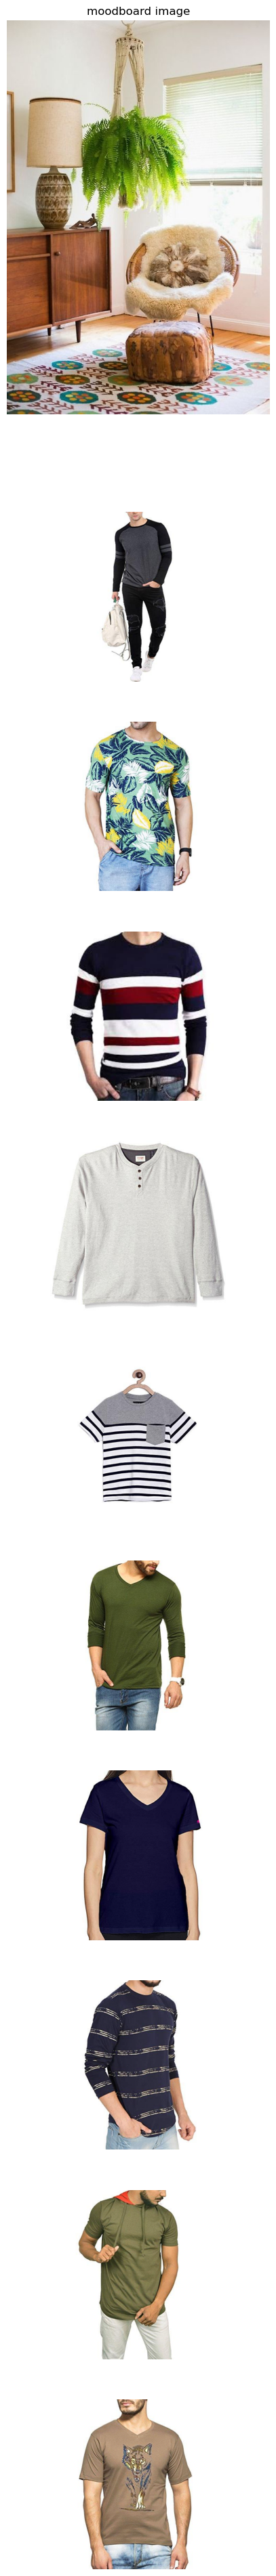

In [130]:
i_moodboard = 2

fig, axes = plt.subplots(1 + 10, 1, 
                         figsize = (5, 50), 
                         gridspec_kw={'height_ratios': [3] + [1] * 10,})

for ax in axes.ravel():
    ax.axis("off")
    
axes[0].imshow(moodboard_images[i_moodboard])
axes[0].set_title("moodboard image")

for iax in range(10):
    ax = axes[iax + 1]
    # map id back from faiss idx to dataset idx
    idx = category_idxs[idxs[i_moodboard][iax]]
    ax.imshow(amazon_dataset2[idx][0])
    ax.set_aspect("equal")

plt.subplots_adjust(hspace=0.2, wspace = 0.0)
plt.show()